In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import GPy
matplotlib.rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica", "Arial"], "size": 7.5})
matplotlib.rc('lines', marker=None, markersize=4.5, linewidth=1.2)

# Import and preprocess data

In [2]:
data = pd.read_csv('..//data//transfer_data.csv', parse_dates=[0, 1])
data['transfer_time'] = (data.t_metro.values.astype(np.int64)//10**9) - (data.t_bus.values.astype(np.int64)//10**9)

# Delete `transfer_time` that larger than 2000s
data = data.loc[(data.transfer_time<2000), :]
# Select 5:00 - 20:00
data = data.loc[(data.t_metro.dt.hour>=5)&(data.t_metro.dt.hour<20), :]
data.sort_values(by='t_bus', inplace=True)

# Determine the walking time by the median value of `transfer_time` during 12:00-4:00 pm:
off_peak_data = data.loc[((data.t_metro.dt.hour>=14)&(data.t_metro.dt.hour<=16))|(data.t_metro.dt.hour==5), 'transfer_time']
walk_time = off_peak_data.median()
data['waiting_second'] = data.transfer_time - walk_time
print(f'Median of walk time during off-peak hour is {walk_time}s')

# Transfer the unit of time
data['weekday'] = data.t_metro.dt.weekday
data['t_metro_hour'] = data.t_metro.dt.hour + data.t_metro.dt.minute/60
data['waiting_minute'] = data.waiting_second/ 60
data.head()

Median of walk time during off-peak hour is 129.0s


,t_metro,t_bus,transfer_time,waiting_second,weekday,t_metro_hour,waiting_minute
157,2015-08-03 05:05:00,2015-08-03 05:04:16,44,-85.0,0,5.083333,-1.416667
172,2015-08-03 05:06:00,2015-08-03 05:04:18,102,-27.0,0,5.100000,-0.450000
602,2015-08-03 05:06:00,2015-08-03 05:04:46,74,-55.0,0,5.100000,-0.916667
348,2015-08-03 05:06:00,2015-08-03 05:04:47,73,-56.0,0,5.100000,-0.933333
163,2015-08-03 05:15:00,2015-08-03 05:11:59,181,52.0,0,5.250000,0.866667


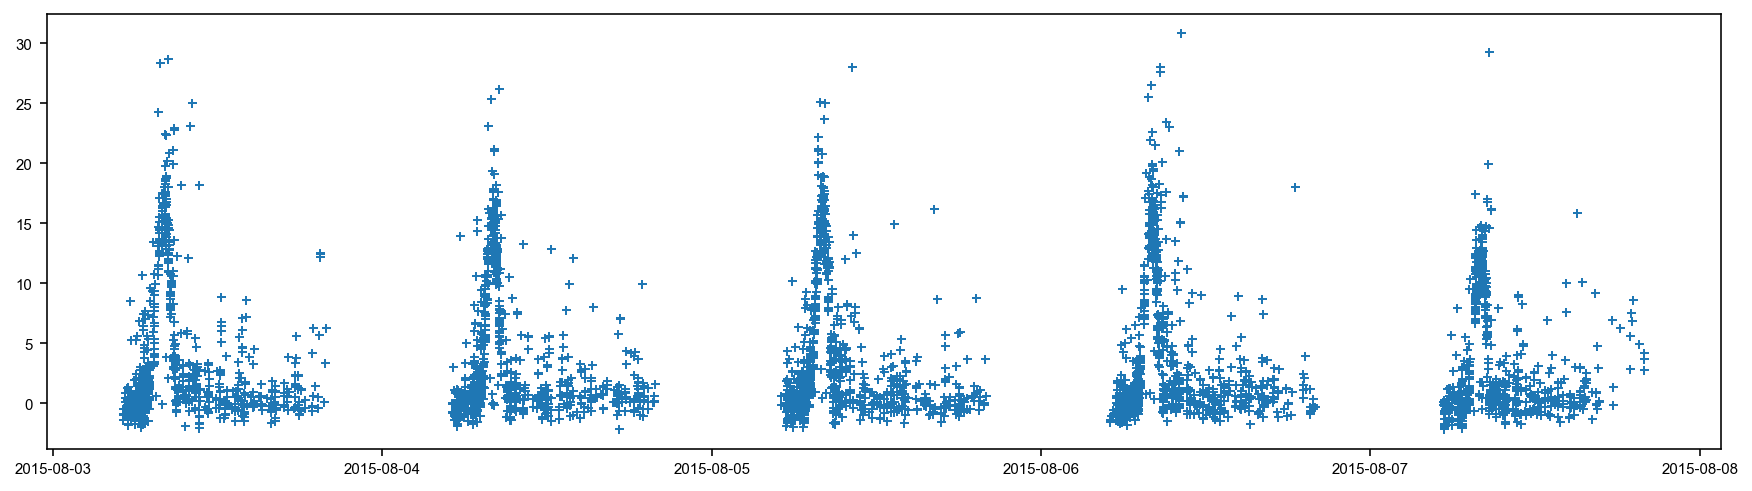

In [3]:
# Plot all data in the five-day period
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(data.t_metro, data.waiting_minute, '+')

# Apply to moving average the first day

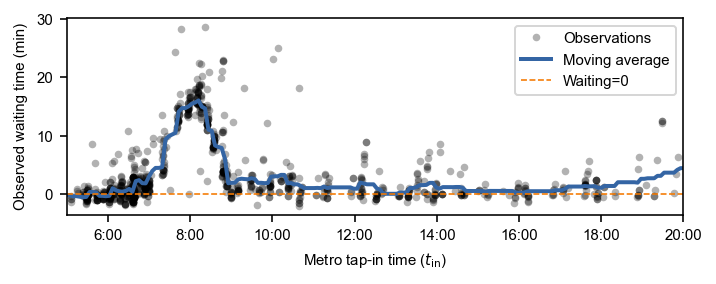

In [4]:
idx = data.weekday == 0
data_sample = data.loc[idx, ['t_metro_hour', 'waiting_minute']].copy()
data_sample.sort_values(by='t_metro_hour', inplace=True)
t_series = data_sample.t_metro_hour.values
w_series = data_sample.waiting_minute.values

def average_value(t_series, w_series, t, n=10, include_same_value=True):
    N = len(t_series)
    pos = (t>t_series).sum()
    pos_low = max(pos-n, 0)
    pos_high = min(pos+n, N-1)

    if include_same_value:
        pos_low_value = t_series[pos_low]
        pos_low = (pos_low_value>t_series).sum()

        pos_high_value = t_series[pos_high]
        pos_high = (pos_high_value>t_series).sum()

    return np.mean(w_series[int(pos_low):int(pos_high)+1])


t_array = np.linspace(4.5, 20.5, 200)
w_array = [average_value(t_series=t_series, w_series=w_series, t=ti, n=15, include_same_value=False) for ti in t_array]

limits = [4.5, 20.5]
fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(data.loc[idx, 't_metro_hour'], data.loc[idx, 'waiting_minute'], 'ok',
        ms=3.8, alpha=0.3, markeredgewidth=0, label='Observations')
ax.plot(t_array, w_array, color='#3465a4', label='Moving average', lw=2)
ax.plot([5, 20], [0,0], '--', color='#f57900', lw=0.8, label='Waiting=0')
plt.legend()
ax.set_xbound(5,20)
ticks = plt.xticks(ticks=range(6, 21, 2), labels=[str(i)+':00' for i in range(6, 21, 2)])
ax.set_ylabel('Observed waiting time (min)')
ax.set_xlabel('Metro tap-in time ($t_\mathrm{in}$)')
fig.set_tight_layout(0.1)

# GP regression with student-$t$ likelihood
## Train

In [5]:
models = []
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
kernel =  GPy.kern.RBF(1, variance=1.0, lengthscale=0.5)
kernel.lengthscale.constrain_bounded(0.4, 1)  # Avoid jagged solution

# Build one GP for each weekday
for weekday in range(5):
    data1 = data.loc[data.weekday==weekday, :]

    models.append(GPy.core.GP(X=data1.t_metro_hour.values[:, None],
                              Y=data1.waiting_minute.values[:, None],
                              kernel = kernel.copy(),
                              likelihood=GPy.likelihoods.StudentT(deg_free=1, sigma2=2),
                              inference_method = GPy.inference.latent_function_inference.Laplace(),
                              name=names[weekday]
                             ))
    t0 = time.time()
    models[weekday].optimize()
    print(models[weekday])
    print(f'Time={time.time() - t0:.2f}s')

reconstraining parameters rbf.lengthscale



Name : Monday
Objective : 2115.340207723747
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  Monday.             |               value  |  constraints  |  priors
  rbf.variance        |   5.131991163109817  |      +ve      |        
  rbf.lengthscale     |  0.4450636770750237  |    0.4,1.0    |        
  Student_T.t_scale2  |  1.0429952408587235  |      +ve      |        
  Student_T.deg_free  |   1.683025171834246  |      +ve      |        
Time=118.71s

Name : Tuesday
Objective : 2073.376755592857
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  Tuesday.            |               value  |  constraints  |  priors
  rbf.variance        |    4.10660826413987  |      +ve      |        
  rbf.lengthscale     |  0.4284209130896468  |    0.4,1.0    |        
  Student_T.t_scale2  |  0.7574710599164699  |      +ve      |        
  Student_T.deg_free  |    1.49138144440008  |      +ve      |        
Time=7

## Visualize GP results

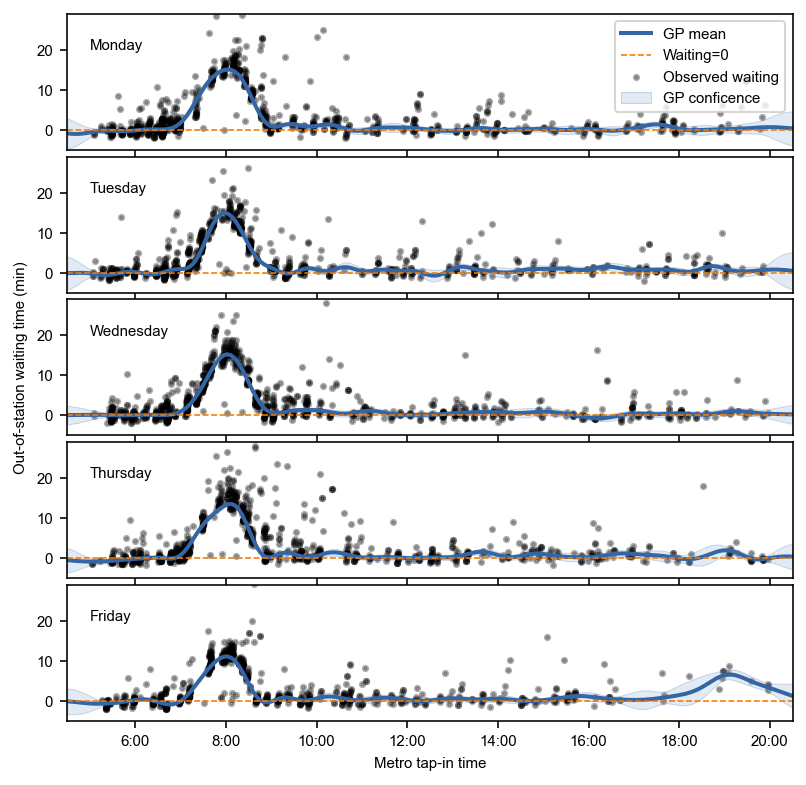

In [6]:
limits = [4.5, 20.5]
fig = plt.figure(figsize=(6.5,6.5))
gs = fig.add_gridspec(5, hspace=0.05)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(5):
    if i ==0:
        labels = ['Observed waiting', 'GP conficence', 'GP mean']
    else:
        labels = [None, None, None]
    models[i].plot_data(ax=axs[i], marker='o', s=4.5, alpha=0.3, linewidths=0, label=labels[0])
    models[i].plot_confidence(plot_limits=limits, ax=axs[i], plot_raw=True, label=labels[1])
    models[i].plot_mean(plot_limits=limits, ax=axs[i], label=labels[2])
    axs[i].text(5, 20, names[i])
    axs[i].plot([4.5, 20.5], [0,0], '--', color='#f57900', lw=0.8, label='Waiting=0')

axs[0].legend(loc='upper right')
axs[4].set_xlabel('Metro tap-in time')
axs[2].set_ylabel('Out-of-station waiting time (min)')
axs[4].set_ybound([-5, 29])
axs[4].set_xbound(limits)
ticks = plt.xticks(ticks=range(6, 21, 2), labels=[str(i)+':00' for i in range(6, 21, 2)])

## Visualize queueing process

In [7]:
mdata = pd.read_csv('..//data/521ttybdtrecords.txt', dtype=np.int32)
mdata.sort_values('start', inplace=True)

# Transfer from seconds to hours
mdata = mdata - 5*3600
mdata = mdata.loc[mdata.start >=0, :]
mdata['weekday'] = (mdata.start//(15*3600)).astype(np.int16)
mdata['hour'] = mdata.start%(15*3600)/3600 + 5

# Calculate cumulative departure/arrival
mdict = {}
for weekday in range(5):
    # Get cumulative departure
    mdict[weekday] = mdata.loc[mdata.weekday==weekday, :].groupby('hour').size().to_frame('boarding').reset_index()
    mdict[weekday]['cum_boarding'] = mdict[weekday]['boarding'].cumsum()

    # Infer the arrival time
    waiting_mean, _ = models[weekday].predict(mdict[weekday].hour.values[:,None])
    waiting_mean[waiting_mean<0] = 0 
    mdict[weekday]['waiting_minute'] = waiting_mean
    mdict[weekday]['arrival'] = mdict[weekday]['hour'] - waiting_mean.ravel()/60

In [8]:
# Calculate per 10 minutes arrival/departure rate
minute5 = 5/60 + 0.001/3600

# A dict for departure/arrival rate
rdict={i:pd.DataFrame(data=np.zeros((31, 3)), columns=['time', 'arrival_rate', 'departure_rate']) for i in range(5)}
for i in range(5):
    rdict[i]['time'] = np.linspace(7-15/60, 9+15/60, 31)
    for j, t in enumerate(rdict[i].time.values):
        # Departure rate every 10 minutes
        hdata = mdict[i].loc[(mdict[i].hour>=(t-minute5))&(mdict[i].hour<=(t+minute5)), :]
        rdict[i].at[j, 'departure_rate'] = (hdata.iat[-1, 2] - hdata.iat[0, 2])/(hdata.iat[-1, 0] - hdata.iat[0, 0])/60
        
        # Arrival rate every "10 minutes"
        adata = mdict[i].loc[(mdict[i].arrival>=(t-minute5))&(mdict[i].arrival<=(t+minute5)), :]
        rdict[i].at[j, 'arrival_rate'] = (adata.iat[-1, 2] - adata.iat[0, 2])/(adata.iat[-1, 4] - adata.iat[0, 4])/60

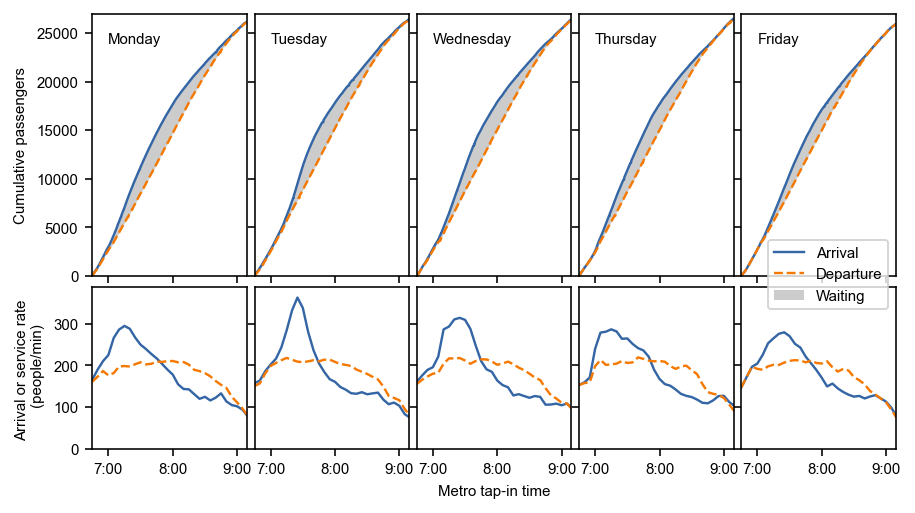

In [9]:
limits = [6.75, 9.15]
fig = plt.figure(figsize=(7.2, 4))
gs = fig.add_gridspec(2, 5, wspace=0.05, hspace=0.05, height_ratios=[0.618, 0.382])
axs = gs.subplots(sharex=True, sharey='row')

for i in range(5):
    # Plot cumulative departure/arrival
    mdata = mdict[i].copy()
    mdata = mdata.loc[(mdata.hour>=limits[0])&(mdata.hour<=limits[1]), :]
    mdata.cum_boarding = mdata.cum_boarding - mdata.cum_boarding.min()
    axs[0][i].plot(mdata['arrival'], mdata['cum_boarding'], label='Arrival', color="#3465a4")
    axs[0][i].plot(mdata['hour'], mdata['cum_boarding'], '--', label='Departure', color="#f57900")
    axs[0][i].fill_betweenx(y=mdata['cum_boarding'], x1=mdata['arrival'], x2=mdata['hour'], color='k', alpha=0.2, label='Waiting', lw=0)
    axs[0][i].text(7, 24000, names[i])
    
    # Plot arrival/departure rate
    rdata = rdict[i]
    axs[1][i].plot(rdata['time'], rdata['arrival_rate'], color="#3465a4")
    axs[1][i].plot(rdata['time'], rdata['departure_rate'], '--', color="#f57900")
    ticks = plt.xticks(ticks=[7,8,9], labels=["7:00", '8:00', "9:00"])
    axs[1][i].set_xbound(limits)

    
axs[0][0].set_ybound([0, 27000])
axs[1][0].set_ybound([0, 390])
axs[0][0].set_ylabel('Cumulative passengers')
axs[1][0].set_ylabel('Arrival or service rate \n (people/min)')
axs[1][2].set_xlabel('Metro tap-in time')
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.5),
           bbox_transform=fig.transFigure)

## Calculate statistics

In [10]:
# Maximum waiting time
for i in range(5):
    print(max(mdict[i].waiting_minute))

15.113922707136485
14.956719267527289
15.253918142054477
13.537961918757665
11.068007530958266


In [11]:
# Average waiting time
for i in range(5):
    mdata = mdict[i].loc[(mdict[i].hour>=7)&(mdict[i].hour<=9), :]
    print((mdata.boarding * mdata.waiting_minute).sum()/mdata.boarding.sum())

9.669044093778217
7.719656110522457
8.466717537876717
7.760420747632211
5.845140111957284


In [12]:
# Total waiting time
for i in range(5):
    mdata = mdict[i].loc[(mdict[i].hour>=7)&(mdict[i].hour<=9), :]
    print((mdata.boarding * mdata.waiting_minute).sum())

219874.06269251666
179041.98417134734
194429.7015398009
180359.93859572022
131655.93588172586


In [13]:
# Total passengers
for i in range(5):
    mdata = mdict[i].loc[(mdict[i].hour>=7)&(mdict[i].hour<=9), :]
    print(mdata.boarding.sum())

22740
23193
22964
23241
22524


In [14]:
# Calculate per 10 minutes arrival/departure rate
minute5 = 5/60 + 0.001/3600

# A dict for departure/arrival rate
rdict2 = {i:pd.DataFrame(data=np.zeros((121, 4)), columns=['time', 'arrival_rate', 'departure_rate', 'queue_length']) for i in range(5)}
for i in range(5):
    rdict2[i]['time'] = np.linspace(7, 9, 121)
    for j, t in enumerate(rdict2[i].time.values):
        # Depature rate every 10 minutes
        hdata = mdict[i].loc[(mdict[i].hour>=(t-minute5))&(mdict[i].hour<=(t+minute5)), :]
        rdict2[i].at[j, 'departure_rate'] = (hdata.iat[-1, 2] - hdata.iat[0, 2])/(hdata.iat[-1, 0] - hdata.iat[0, 0])/60
        
        # Arrival rate every "10 minutes"
        adata = mdict[i].loc[(mdict[i].arrival>=(t-minute5))&(mdict[i].arrival<=(t+minute5)), :]
        rdict2[i].at[j, 'arrival_rate'] = (adata.iat[-1, 2] - adata.iat[0, 2])/(adata.iat[-1, 4] - adata.iat[0, 4])/60

In [15]:
# Max arrival rate
for i in range(5):
    print(rdict2[i].arrival_rate.max())

295.25030714686545
384.4072639800659
318.92227709609443
301.8978463844138
279.7871706161416


In [16]:
# Max departure rate
for i in range(5):
    print(rdict2[i].departure_rate.max())

212.19999999999965
220.0999999999996
219.2999999999996
219.5000000000008
215.3999999999996


In [17]:
# The time with the maximum queueing length
for i in range(5):
    rdata = rdict2[i].loc[0:90]
    t = rdata.loc[rdata.arrival_rate > rdata.departure_rate, 'time'].max()
    print(t)
    print(t%1*60)

7.8
47.999999999999986
7.716666666666667
43.00000000000001
7.733333333333333
44.0
7.866666666666667
52.00000000000003
7.816666666666666
48.999999999999986


In [18]:
# Queueing length
from scipy import interpolate
limits = [6.75, 9.15]

for i in range(5):
    # Plot cumulative departure/arrival
    mdata = mdict[i].copy()
    mdata = mdata.loc[(mdata.hour>=limits[0])&(mdata.hour<=limits[1]), :]
    mdata['queue_length'] = 0
    f = interpolate.interp1d(mdata.hour.values, mdata.cum_boarding.values, fill_value='extrapolate')
    mdata['queue_length'] = mdata.cum_boarding - f(mdata.arrival.values)
    print(mdata.queue_length.max())

3190.784541427285
3188.257292040511
3251.142826110863
2893.3581171828373
2310.395769560273


In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jan 24 2022

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

scipy     : 1.6.1
pandas    : 1.2.1
matplotlib: 3.3.3
numpy     : 1.20.1
GPy       : 1.9.9

Watermark: 2.3.0

